In [1]:
# install packages
!pip install librosa
!pip install pywt
!pip install matplotlib
!pip install noisereduce

ERROR: Could not find a version that satisfies the requirement pywt (from versions: none)
ERROR: No matching distribution found for pywt


In [2]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal
import noisereduce as nr
import pywt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import itertools

In [3]:
def get_high_pass_filter(cutoff_freq, sr):
    nyquist = 0.5 * sr
    normal_cutoff = cutoff_freq / nyquist
    return scipy.signal.butter(1, normal_cutoff, btype='high', analog=False)

def band_stop_filter(y, sr, highcut, order=4):
    nyquist = 0.5 * sr
    normal_cutoff = highcut / nyquist
    b, a = scipy.signal.butter(order, normal_cutoff, btype='high', analog=False)
    y_filtered = scipy.signal.filtfilt(b, a, y)
    return y_filtered

def reduce_noise(y, sr, noise_sample, n_fft=2048, hop_length=512, n_std_thresh=1.5):
    noise_stft = librosa.stft(noise_sample, n_fft=n_fft, hop_length=hop_length)
    noise_stft_db = librosa.amplitude_to_db(np.abs(noise_stft), ref=np.max)
    
    mean_freq_noise = np.mean(noise_stft_db, axis=1)
    std_freq_noise = np.std(noise_stft_db, axis=1)
    
    audio_stft = librosa.stft(y, n_fft=n_fft, hop_length=hop_length)
    audio_stft_db = librosa.amplitude_to_db(np.abs(audio_stft), ref=np.max)
    
    thresh = mean_freq_noise + n_std_thresh * std_freq_noise
    mask = audio_stft_db > thresh[:, np.newaxis]
    audio_stft_db_masked = np.where(mask, audio_stft_db, thresh[:, np.newaxis])
    
    audio_stft_db_masked_lin = librosa.db_to_amplitude(audio_stft_db_masked)
    
    y_denoised = librosa.istft(audio_stft_db_masked_lin, hop_length=hop_length)
    
    return y_denoised

In [4]:
# target audio file
flight_train_path = '../audios/Barn Owl Nestling\'s Adorable Flight Training Session!.mp3'
y_ft, sr_ft = librosa.load(flight_train_path)

y_ft = band_stop_filter(y_ft, sr_ft, highcut=900)

In [5]:
def produce_spectrogram(y, sr, cutoff_freq, method='stft', amplitude_t=0, dur=20):
    y_filtered = y
    if dur != -1:
        y_filtered = y_filtered[:int(dur * sr)]
    if method == 'stft':
        D_filtered = librosa.stft(y_filtered)
        S_db_filtered = librosa.amplitude_to_db(np.abs(D_filtered), ref=np.max)
        S_raw_filtered = np.abs(D_filtered)

        print(f"Shape of D_filtered: {D_filtered.shape}")
        print(f"Shape of S_raw_filtered: {S_raw_filtered.shape}")

        plt.figure(figsize=(12, 8))

        librosa.display.specshow(S_raw_filtered, sr=sr, x_axis='time', y_axis='log')

        plt.ylim(512, sr // 2)

        plt.colorbar(format='%+2.0f amplitude')
        plt.title(f'Spectrogram (Frequency vs. Time) with High-Pass Filter at {cutoff_freq}Hz')
        plt.xlabel('Time (s)')
        plt.ylabel('Frequency (Hz)')
        plt.clim(vmin=amplitude_t)
        plt.show()

        # max amplitude
        frequencies = librosa.fft_frequencies(sr=sr, n_fft=D_filtered.shape[0])
        times = librosa.frames_to_time(np.arange(S_db_filtered.shape[1]), sr=sr, hop_length=512, n_fft=2048)
        peak_frequencies = frequencies[np.clip(np.argmax(S_db_filtered, axis=0), 0, len(frequencies) - 1)]

        plt.figure(figsize=(12, 8))
        plt.plot(times, peak_frequencies, label='Peak Frequency')
        plt.ylim(512, sr // 2)
        plt.xlabel('Time (s)')
        plt.ylabel('Frequency (Hz)')
        plt.title(f'Peak Frequency Over Time for First {dur} Seconds')
        plt.legend()
        plt.show()
    if method == 'wavelet':
        scales = np.arange(1, 64)
        
        coef, freq = pywt.cwt(y_filtered, scales, 'cmor', sampling_period=1/sr)
        
        plt.figure(figsize=(12, 8))
        plt.imshow(np.abs(coef), extent=[0, dur, scales[-1], scales[0]], cmap='viridis', aspect='auto',
                   vmax=np.abs(coef).max(), vmin=-np.abs(coef).max())
        plt.colorbar(label='Magnitude')
        plt.title('Wavelet Transform (CWT) of the Audio Signal')
        plt.xlabel('Time (s)')
        plt.ylabel('Scale')
        plt.yscale('log')
        plt.ylim(scales[-1], scales[0])
        plt.show()
        
        peak_frequencies = freq[np.argmax(np.abs(coef), axis=0)]
        times = np.linspace(0, dur, len(peak_frequencies))

        plt.figure(figsize=(12, 8))
        plt.plot(times, peak_frequencies, label='Peak Frequency')
        plt.ylim(512, 10000)
        plt.xlabel('Time (s)')
        plt.ylabel('Frequency (Hz)')
        plt.title(f'Peak Frequency Over Time for First {dur} Seconds')
        plt.legend()
        plt.show()

In [6]:
def filter_response_plots(y, sr, freq):
    b, a = get_high_pass_filter(freq, sr_ft)
    w, h = scipy.signal.freqz(b, a)

    plt.figure(figsize=(12, 8))

    plt.subplot(2, 1, 1)
    plt.plot(0.5 * sr * w / np.pi, np.abs(h), 'b')
    plt.title('High-Pass Filter Frequency Response - Gain')
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Gain')
    plt.grid()

    plt.subplot(2, 1, 2)
    plt.plot(0.5 * sr * w / np.pi, np.angle(h), 'b')
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Phase [radians]')
    plt.grid()

    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 1, 1)
    magnitude_dB = 20 * np.log10(np.abs(h))  # Convert magnitude to dB
    plt.plot(0.5 * sr * w / np.pi, magnitude_dB, 'b')
    plt.title('High-Pass Filter Frequency Response - dB')
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Gain [dB]')
    plt.grid()

    plt.subplot(2, 1, 2)
    plt.plot(0.5 * sr * w / np.pi, np.angle(h), 'b')
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Phase [radians]')
    plt.grid()

    plt.tight_layout()
    plt.show()

Shape of D_filtered: (1025, 5600)
Shape of S_raw_filtered: (1025, 5600)


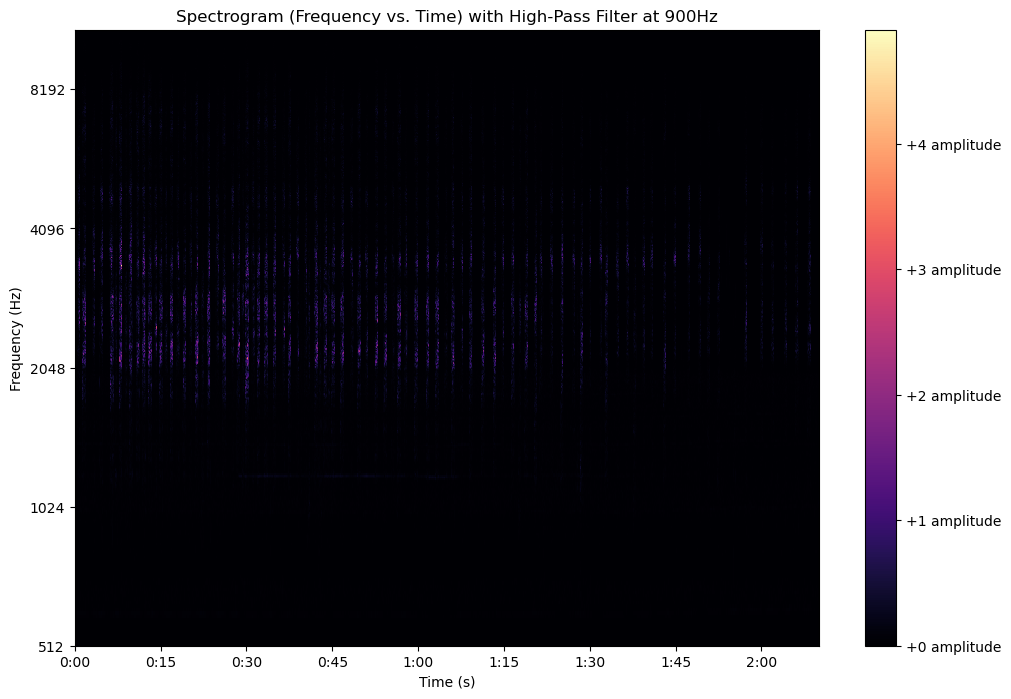

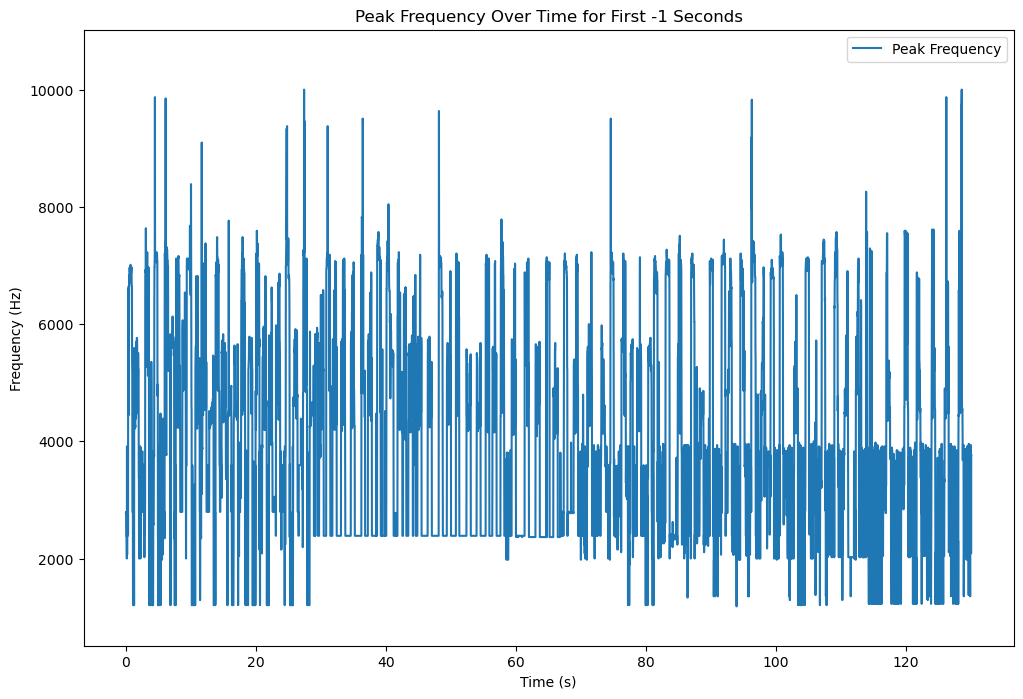

In [7]:
produce_spectrogram(y_ft, sr_ft, 900, method='stft', dur=-1)

/Users/dpr12/anaconda3/lib/python3.11/site-packages/pywt/_cwt.py:117: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should takethe form cmorB-C where B and C are floats representing the bandwidth frequency and center frequency, respectively (example: cmor1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)


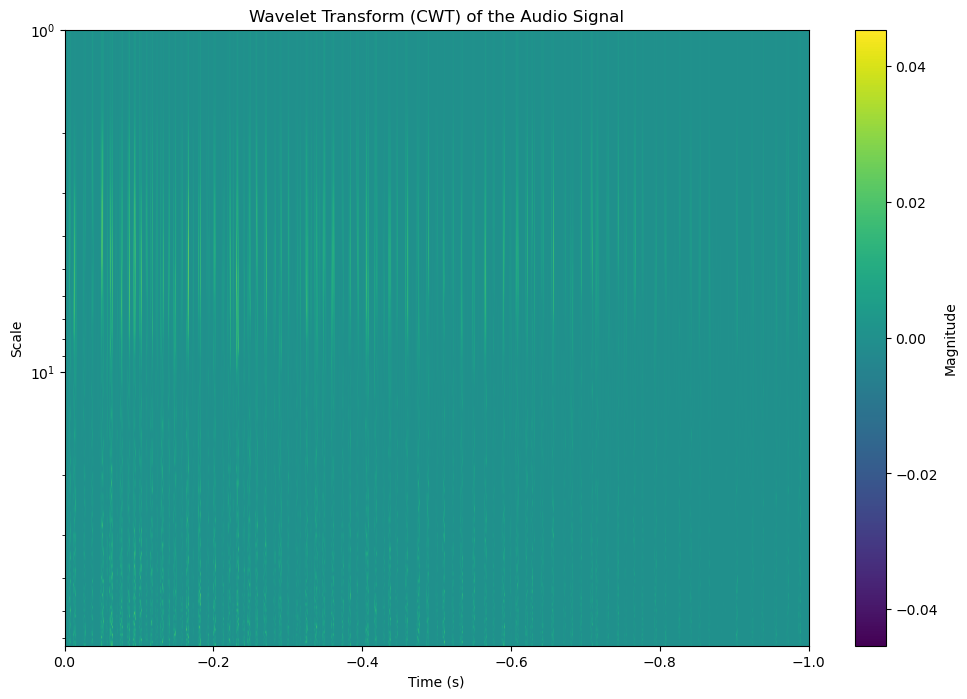

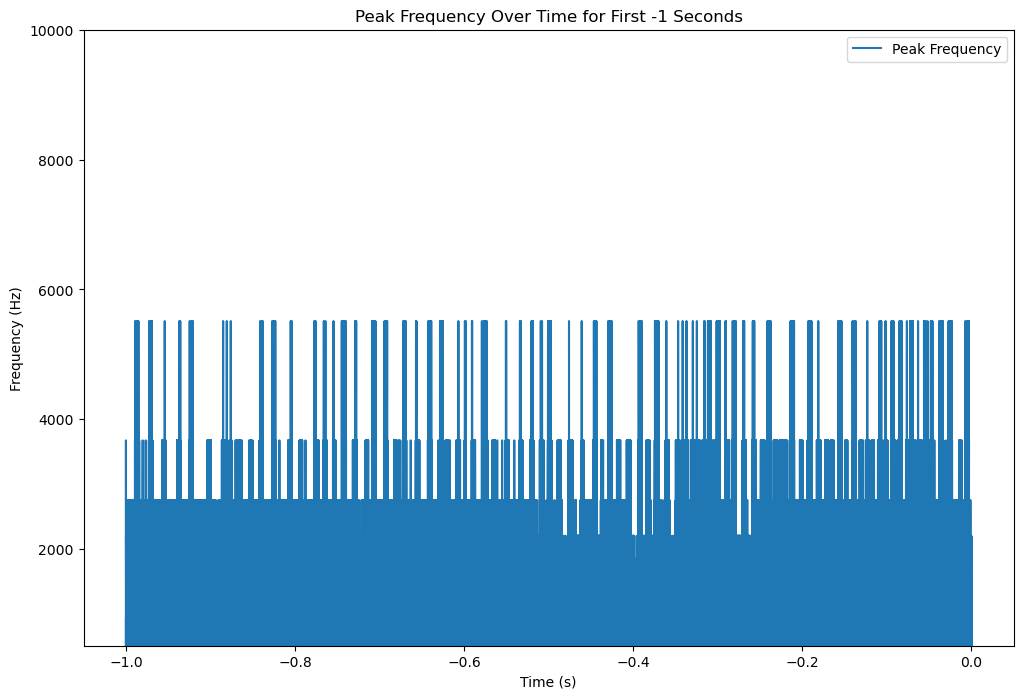

In [8]:
produce_spectrogram(y_ft, sr_ft, 900, method='wavelet', dur=-1)

In [9]:
def detect_energy_peaks(S_filtered, sr, height, distance):
    energy_over_time = np.sum(S_filtered, axis=0)
    
    peaks, _ = scipy.signal.find_peaks(energy_over_time, height=height, distance=distance)
    
    baseline_energy = []
    for i in range(len(peaks) - 1):
        start_idx = peaks[i]
        end_idx = peaks[i + 1]
        baseline_seg = energy_over_time[start_idx: end_idx]
        
        baseline_val = baseline_seg[baseline_seg < np.median(baseline_seg)]
        baseline_energy.extend(baseline_val)
        
    amp_threshold = np.mean(baseline_energy) + np.std(baseline_energy)
    
    print(f'mean: {np.mean(baseline_energy)}')
    print(f'amp threshold: {amp_threshold}')
    
    times = librosa.frames_to_time(peaks, sr=sr)
    full_times = librosa.frames_to_time(np.arange(S_filtered.shape[1]), sr=sr, hop_length=512)
    
    plt.figure(figsize=(10, 6))
    plt.plot(full_times, energy_over_time, label='Energy Over Time (Raw Amplitude)')
    plt.scatter(times, energy_over_time[peaks], color='red', label='Detected Peaks')

    time_segments = []
    start_end_times = []

    for peak_idx in peaks:
        start_idx = peak_idx
        while start_idx > 0 and energy_over_time[start_idx] > amp_threshold:
            start_idx -= 1
        
        end_idx = peak_idx
        while end_idx < len(energy_over_time) - 1 and energy_over_time[end_idx] > amp_threshold:
            end_idx += 1

        start_time = librosa.frames_to_time(start_idx, sr=sr, hop_length=512)
        end_time = librosa.frames_to_time(end_idx, sr=sr, hop_length=512)
        
        if start_time < end_time:
            time_segments.append((start_time, end_time))
            start_end_times.append((start_time, end_time))

    for (start_time, end_time) in start_end_times:
        plt.fill_between(full_times, energy_over_time, where=((full_times >= start_time) & (full_times <= end_time)),
                         color='yellow', alpha=0.3, label='Detected Interval' if start_time == start_end_times[0][0] else "")

    plt.xlabel('Time (s)')
    plt.ylabel('Energy (Sum of Raw Amplitudes)')
    plt.title('Energy Over Time with Detected Peaks and Trimmed Intervals')
    plt.legend()
    plt.show()

    print(f'# of snippets: {len(time_segments)}')
    
    return time_segments, energy_over_time

def decompose_freq(y, sr, height, distance, time_seg_dur=0.2, dur=20):
    if dur != -1:
        y = y[:int(dur * sr)]
        
    D_filtered = librosa.stft(y)
    S_filtered = np.abs(D_filtered)
        
    time_segments, energy_over_time = detect_energy_peaks(S_filtered, sr, height=height, distance=distance)
    
    plt.figure(figsize=(10, 6))

    for start_time, end_time in time_segments:
        start_idx = librosa.time_to_frames(start_time, sr=sr)
        end_idx = librosa.time_to_frames(end_time, sr=sr)

        segment_slice = S_filtered[:, start_idx:end_idx]
        avg_spectrum = np.mean(segment_slice, axis=1)

        frequencies = librosa.fft_frequencies(sr=sr, n_fft=D_filtered.shape[0] * 2 - 1)

        plt.plot(frequencies, avg_spectrum, label=f"Time {start_time:.2f}-{end_time:.2f}s")
        
    plt.ylim(0, None)
    plt.xlim(512, sr // 2)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude (Raw)')
    plt.title('Frequency Decomposition for All Time Intervals')

    plt.legend()
    plt.show()
    
    return time_segments


mean: 5.006062685016096
amp threshold: 12.912951693005999


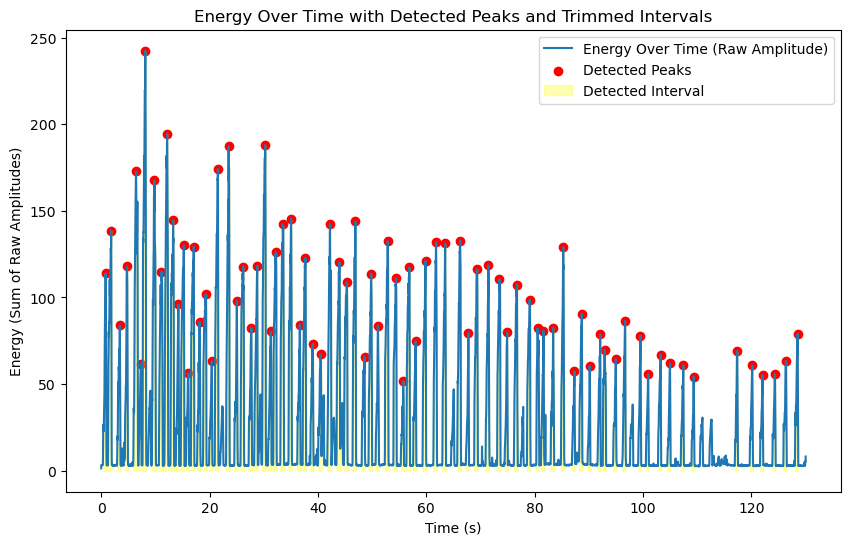

# of snippets: 79


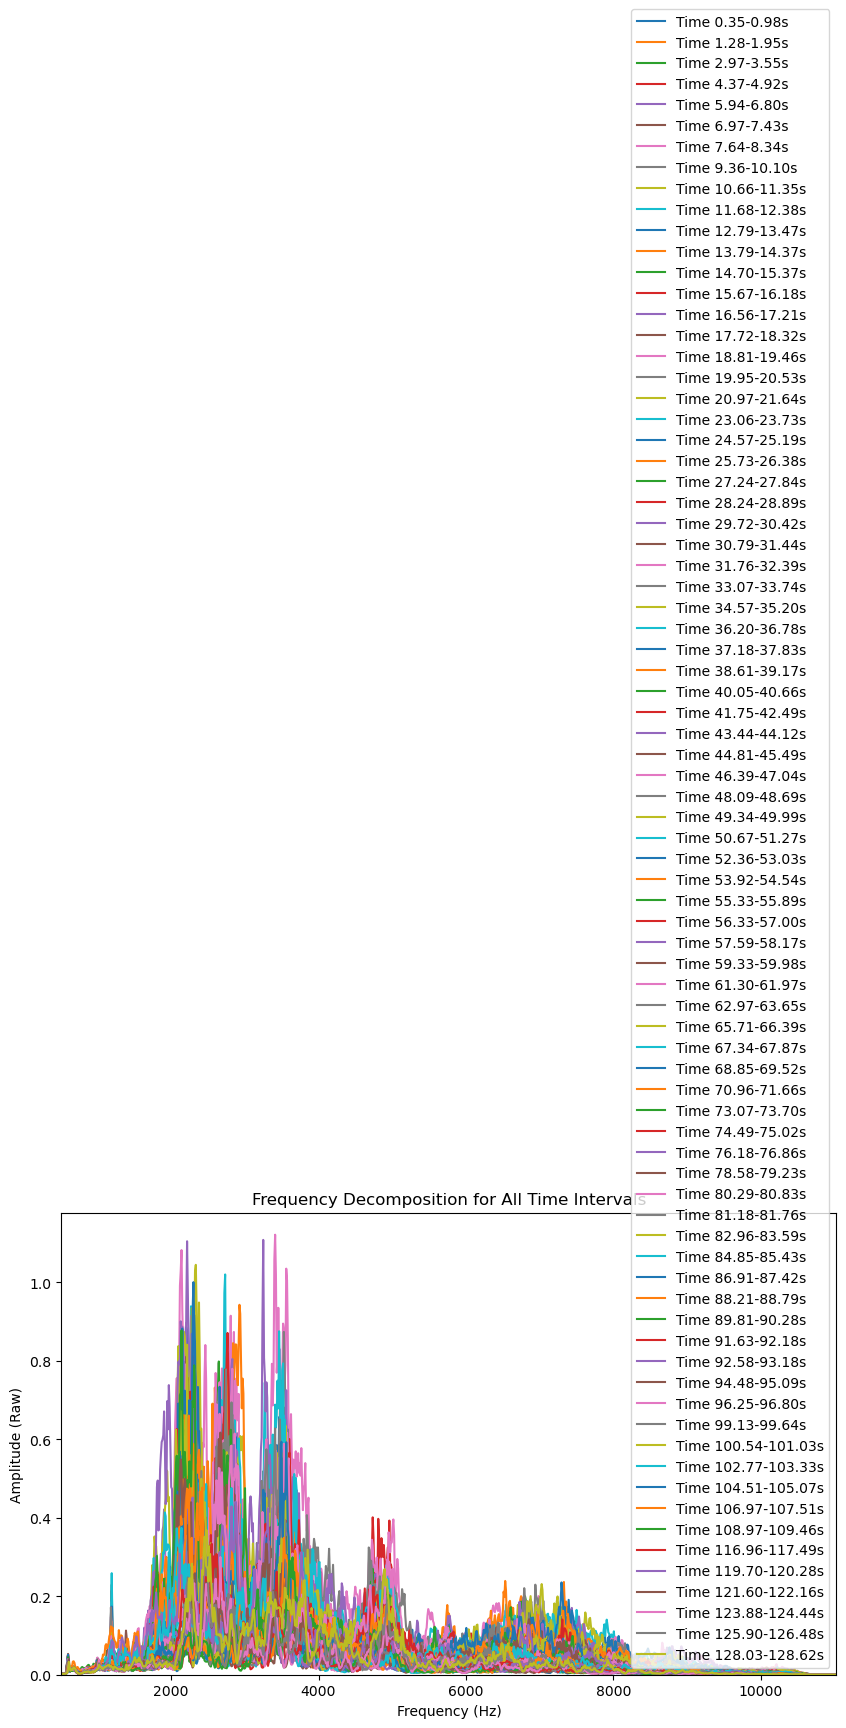

In [10]:
time_segments = decompose_freq(y_ft, sr_ft, dur=-1, height=50, distance=25)

In [11]:
def generate_pairs(n):
    pairs = list(itertools.combinations(range(n), 2))
    return pairs

def perform_pca_on_segments(y, sr, time_segments, n_comp=4):       
    D_filtered = librosa.stft(y)
    S_filtered = np.abs(D_filtered)
    
    data_matrix = []
    
    for start_time, end_time in time_segments:
        start_idx = librosa.time_to_frames(start_time, sr=sr)
        end_idx = librosa.time_to_frames(end_time, sr=sr)
        
        segment_slice = S_filtered[:, start_idx:end_idx]
        avg_spectrum = np.mean(segment_slice, axis=1)
        
        data_matrix.append(avg_spectrum)
        
    data_matrix = np.array(data_matrix)
    
    scaler = StandardScaler()
    data_matrix_std = scaler.fit_transform(data_matrix)
    
    pca = PCA(n_components=n_comp)
    pca_result = pca.fit_transform(data_matrix_std)
    
    explained_variance = pca.explained_variance_ratio_
    print(f'Explained variance by the components: {explained_variance}')

    component_pairs = generate_pairs(n_comp)
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))  # 2 rows and 3 columns for 6 plots

    for ax, (i, j) in zip(axes.flat, component_pairs):
        ax.scatter(pca_result[:, i], pca_result[:, j], c='blue', marker='o')
        ax.set_title(f'PCA Components {i+1}-{j+1}')
        ax.set_xlabel(f'PC {i+1} ({explained_variance[i]*100:.2f}% variance)')
        ax.set_ylabel(f'PC {j+1} ({explained_variance[j]*100:.2f}% variance)')

    plt.tight_layout()
    plt.show()

Explained variance by the components: [0.42562991 0.09386636 0.04379118 0.03944041]


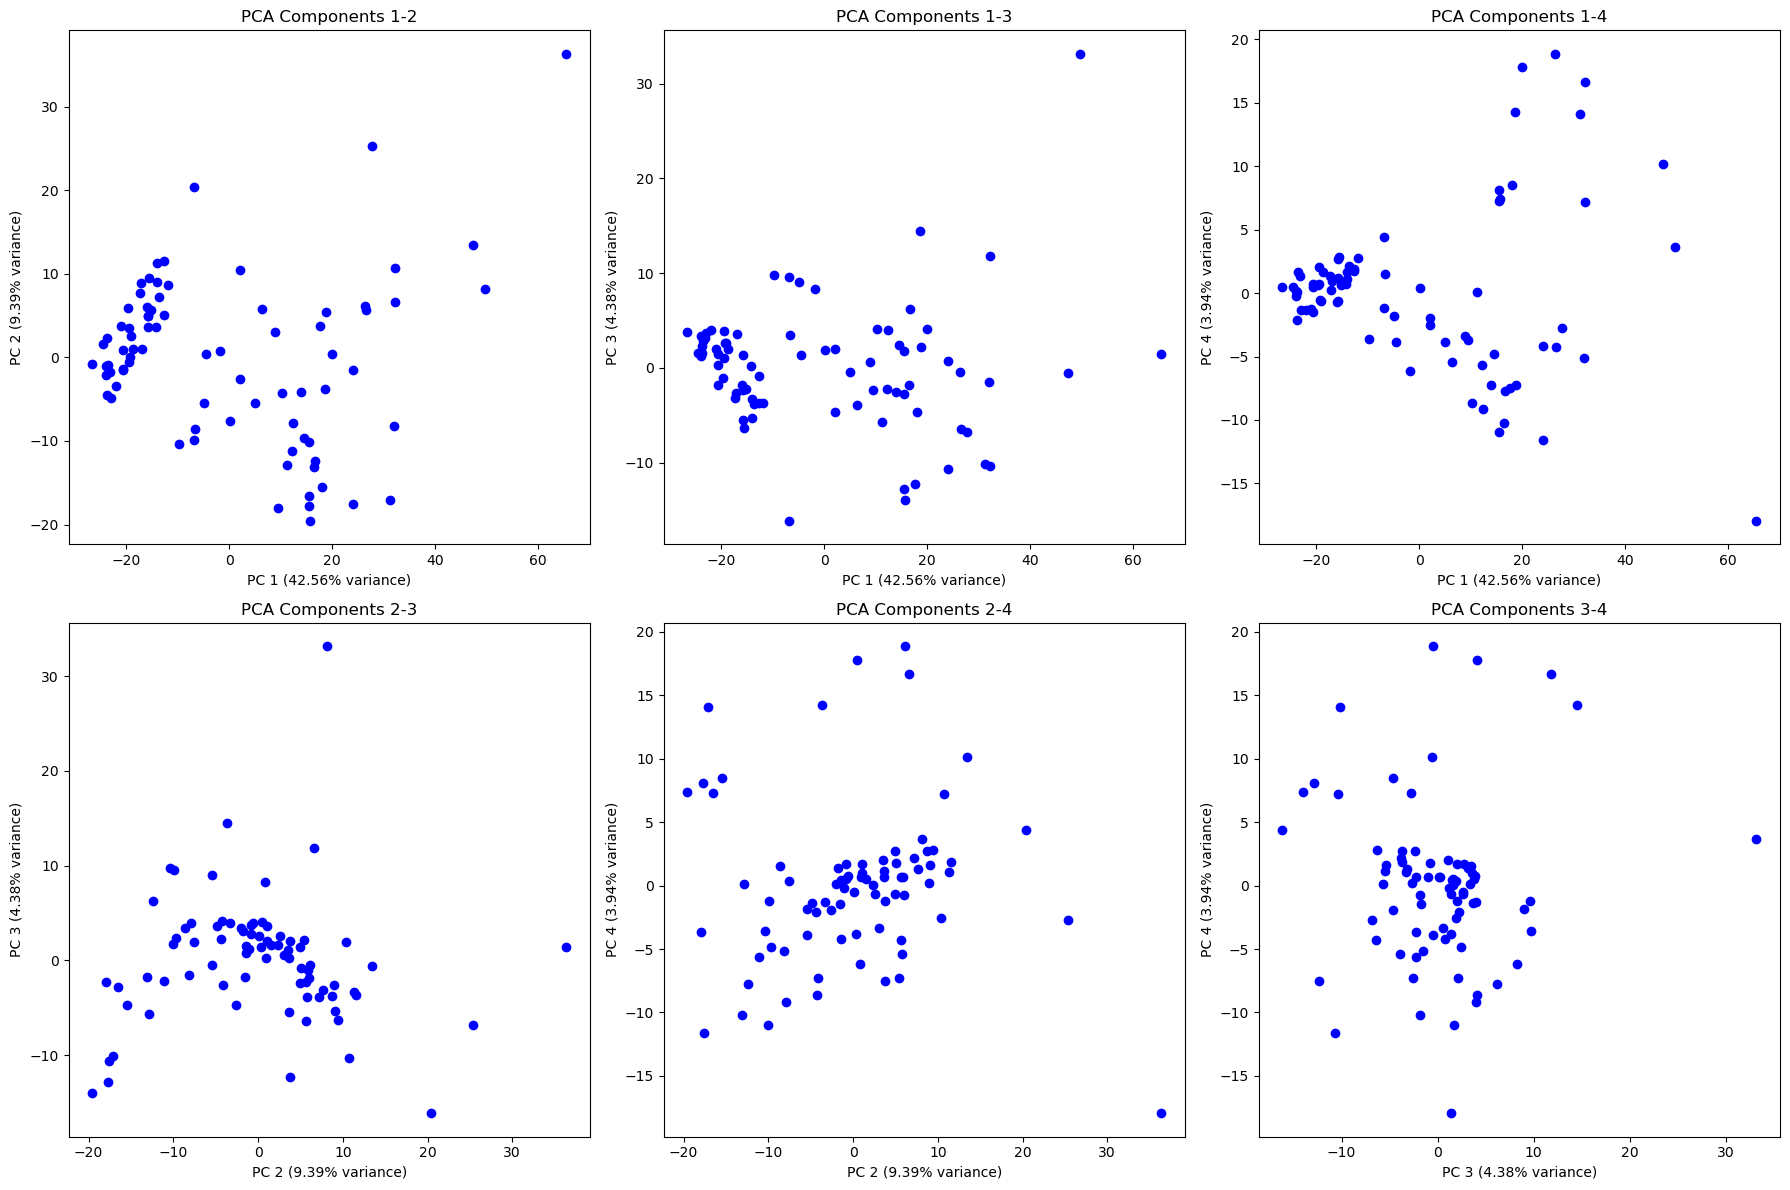

In [12]:
perform_pca_on_segments(y_ft, sr_ft, time_segments)